In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
all_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

In [3]:
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
import matplotlib
import pydicom
import cv2
import ast
import warnings
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
!conda install -c conda-forge gdcm -y
import gdcm


warnings.filterwarnings('ignore')

# Package designed to manipulate data elements in DICOM files 


#Image Transformation
from pydicom.pixel_data_handlers.util import apply_voi_lut

from fastai.vision.all import *
from fastai.medical.imaging import *

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_0         3.1 MB  conda-forge
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
    libjpeg-turbo-2.1.0        |       h7f98852_0         987 KB  conda-forge
    ---------------------------------

In [4]:
path = '../input/siim-covid19-detection'

In [5]:
os.listdir(path)

['sample_submission.csv',
 'train_image_level.csv',
 'test',
 'train',
 'train_study_level.csv']

In [6]:
pwd

'/kaggle/working'

# Dataframes

In [7]:
train_image = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
train_study = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')

In [8]:
train_image

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d


In [9]:
len(train_image)

6334

In [10]:
len(train_image['StudyInstanceUID'].unique())

6054

In [11]:
train_study

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


In [12]:
len(train_study['id'].unique())

6054

In [13]:
train_image['split_label'] = train_image.label.apply(lambda x: [x.split()[offs:offs+6] for offs in range(0, len(x.split()), 6)])
train_image.head(5)

,id,boxes,label,StudyInstanceUID,split_label
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]"
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[[none, 1, 0, 0, 1, 1]]"
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[[opacity, 1, 677.42216, 197.97662, 1545.21983, 1197.75876], [opacity, 1, 1792.69064, 402.5525, 2409.71798, 1606.9105]]"
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[[opacity, 1, 2729, 2181.33331, 3677.00012, 2785.33331]]"
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[[opacity, 1, 623.23328, 1050, 1337.23328, 2156], [opacity, 1, 2578.56661, 998.66667, 3241.23328, 2118.66667]]"


In [14]:
class_frequency = []
for i in range(len(train_image)):
    for j in train_image.iloc[i].split_label:
        class_frequency.append(j[0])
class_frequency.count('opacity')

7853

Text(0, 0.5, 'Frequency')

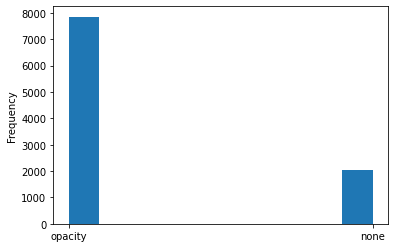

In [15]:
plt.hist(class_frequency)
plt.ylabel('Frequency')

In [16]:
df = train_study.groupby(['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']).count().reset_index()
df['label'] = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
df['perc'] = df["id"]/df["id"].sum()*100

In [17]:
df.head()

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,id,label,perc
0,0,0,0,1,474,Negative for Pneumonia,7.829534
1,0,0,1,0,1049,Typical Appearance,17.327387
2,0,1,0,0,2855,Indeterminate Appearance,47.158903
3,1,0,0,0,1676,Atypical Appearance,27.684176


# Plot images

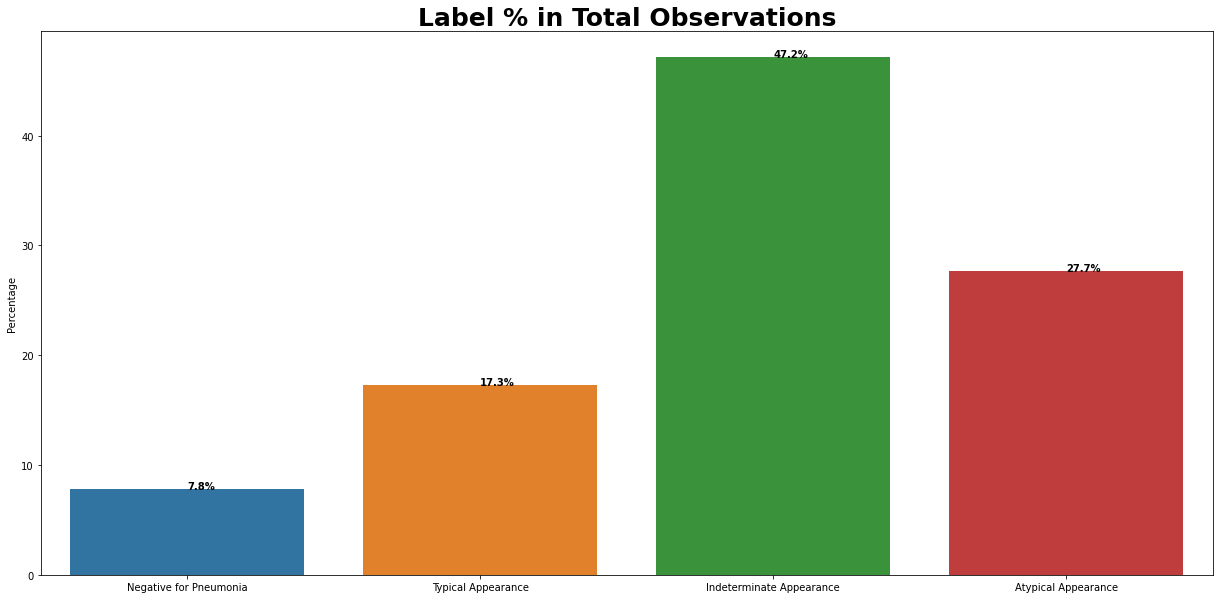

In [18]:
# Plot
bar,ax = plt.subplots(figsize=(21,10))
ax = sns.barplot(x=df["label"], y=df["perc"], 
                 ci=None)
ax.set_title("Label % in Total Observations", fontsize=25,
             weight = "bold")
ax.set_xlabel(" ")
ax.set_ylabel("Percentage")
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(),
             "%.1f%%"% rect.get_height(), weight='bold')

In [19]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # 'VOI LUT' is used to transform raw DICOM data to "human-friendly" view.
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted -> fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(5, 5), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=5, is_rgb=True, title="", cmap='gray', img_size=(300,300)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

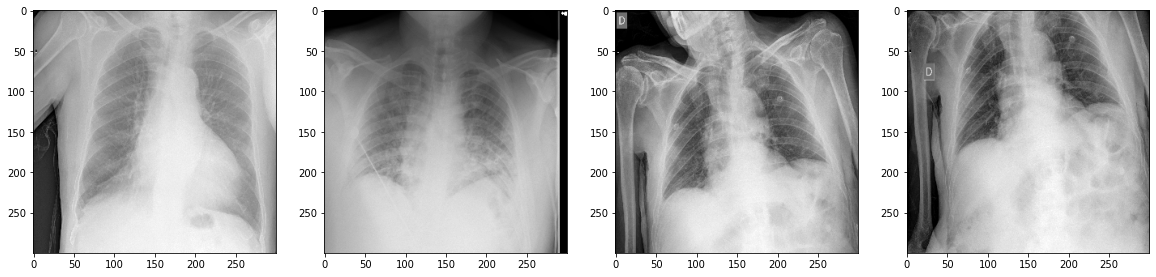

In [20]:
dicom_paths = get_dicom_files('../input/siim-covid19-detection/train')
imgs = [dicom2array(path) for path in dicom_paths[:4]]
plot_imgs(imgs)

In [21]:
from pydicom import dcmread, read_file
from pydicom.data import get_testdata_file
single_file_path = "../input/siim-covid19-detection/train/00086460a852/9e8302230c91/65761e66de9f.dcm"
# PATH+"train/00086460a852/9e8302230c91/65761e66de9f.dcm"
dicom_sf = read_file(single_file_path, stop_before_pixels=False)

In [22]:
img=dicom_sf.pixel_array
type(img), img.shape

(numpy.ndarray, (2330, 2783))

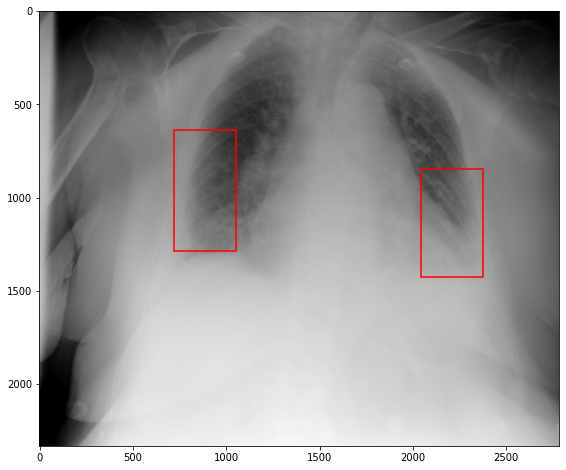

In [23]:
box = train_image.loc[train_image['id']=='65761e66de9f_image'].reset_index(drop=True)
from ast import literal_eval

import matplotlib.patches as patches
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img, cmap="gray")
# Create a Rectangle patch
rect1 = patches.Rectangle((720.65215, 636.51048), 332.19348, 648.12561, linewidth=1.5, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((2044.77989, 847.90622), 329.87049, 576.11169, linewidth=1.5, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

In [24]:
from ast import literal_eval
def get_samples(num):
    study_df_grp = pd.melt(train_study, id_vars=list(train_study.columns)[:1], value_vars=list(train_study.columns)[1:],
             var_name='label', value_name='value')
    study_df_grp = study_df_grp.loc[study_df_grp['value']!=0].reset_index(drop=True)
    labels = list(study_df_grp['label'].unique())
    study_samples = {}
    for label in labels:
        study_ids = study_df_grp.loc[study_df_grp['label'] == label].sample(num)['id'].tolist() 
        #Get num sample rows from the datafame
        samples = []
        for study_id in study_ids:
            image = {}
            study_instance_id = study_id.split('_')[0]
            image_id = train_image.loc[train_image['StudyInstanceUID']==study_instance_id]['id'].values[0].split('_')[0] #Get the image matching study id
            file_name = [string for string in all_files if image_id in string]
            image['study_id'] = study_instance_id
            image['dicom_file'] = file_name[0]
            #Get the bounding boxes
            box = None
            try:
                box = literal_eval(train_image.loc[train_image['StudyInstanceUID']==study_instance_id]['boxes'].values[0])
            except ValueError:
                pass
            image['boxes'] = box
            samples.append(image)
        study_samples[label] = samples
    return study_samples

samples = get_samples(6)

def display_all_class_samples():
    ''' Input : List of samples 
    '''
    all_class_samples = []
    for key in samples:
        sample_dict = samples[key][0]
        sample_dict['class'] = key
        all_class_samples.append(sample_dict)
    fig1, ax1 = plt.subplots(1,4, figsize=(18, 5), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(all_class_samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if 'boxes' in item and item['boxes'] is not None:
            for box in item['boxes']:             
                rect = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('{}'.format(item['class']),fontsize = 18)    
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle('Samples across all classes',fontsize = 20)
    plt.show()

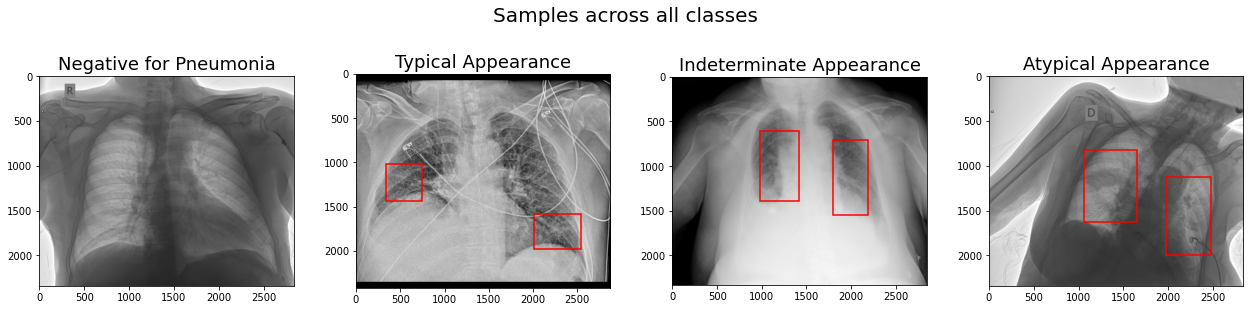

In [25]:
display_all_class_samples()

# Negetive for Pneumonia 

In [26]:
def display_samples(samples, title, draw_boxes=False):
    ''' Input : List of samples 
    '''
    fig1, ax1 = plt.subplots(2,3, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(samples, axs):
        dicom = read_file(item['dicom_file'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if draw_boxes == True and item['boxes'] is not None:
            for box in item['boxes']:             
                rect = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('Study : {}'.format(item['study_id']),fontsize = 18)
        
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle(title,fontsize = 20)
    plt.show()

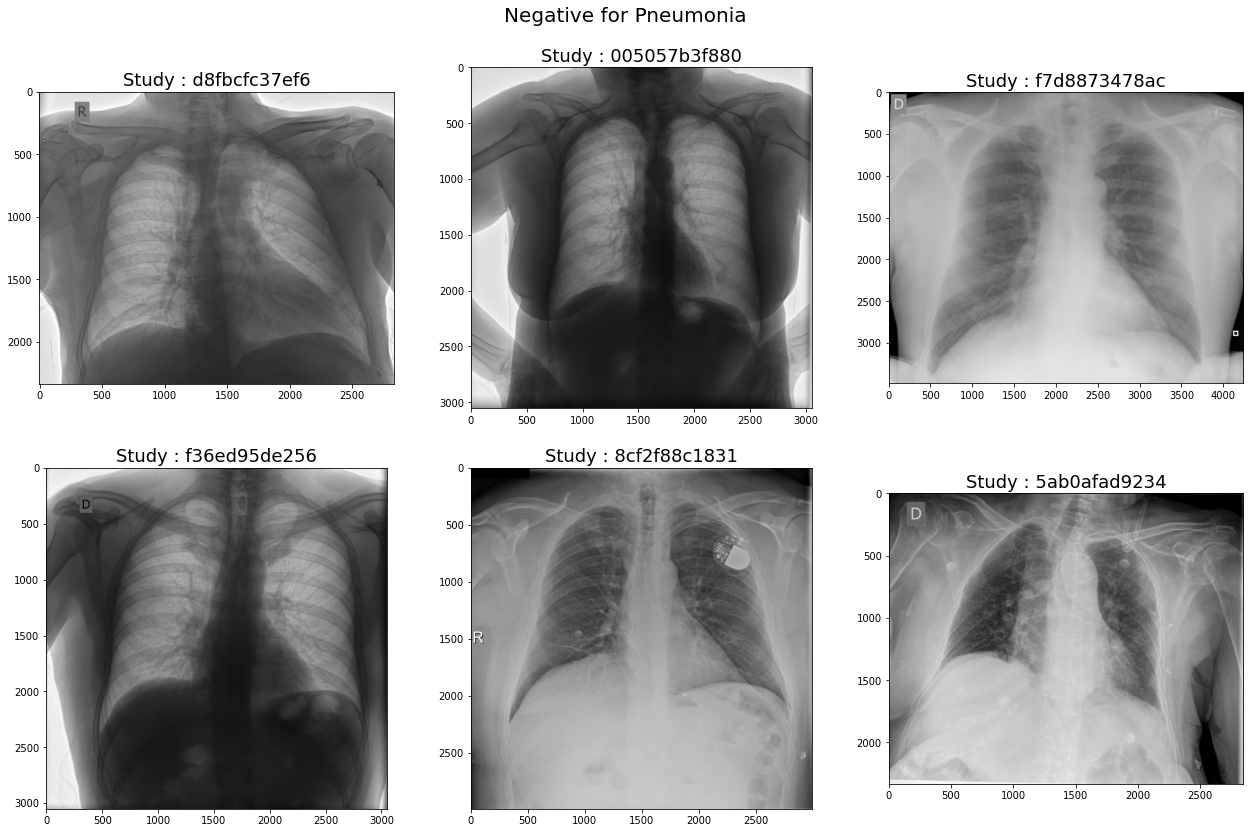

In [27]:
display_samples(samples['Negative for Pneumonia'],'Negative for Pneumonia')

# Typical Apearance

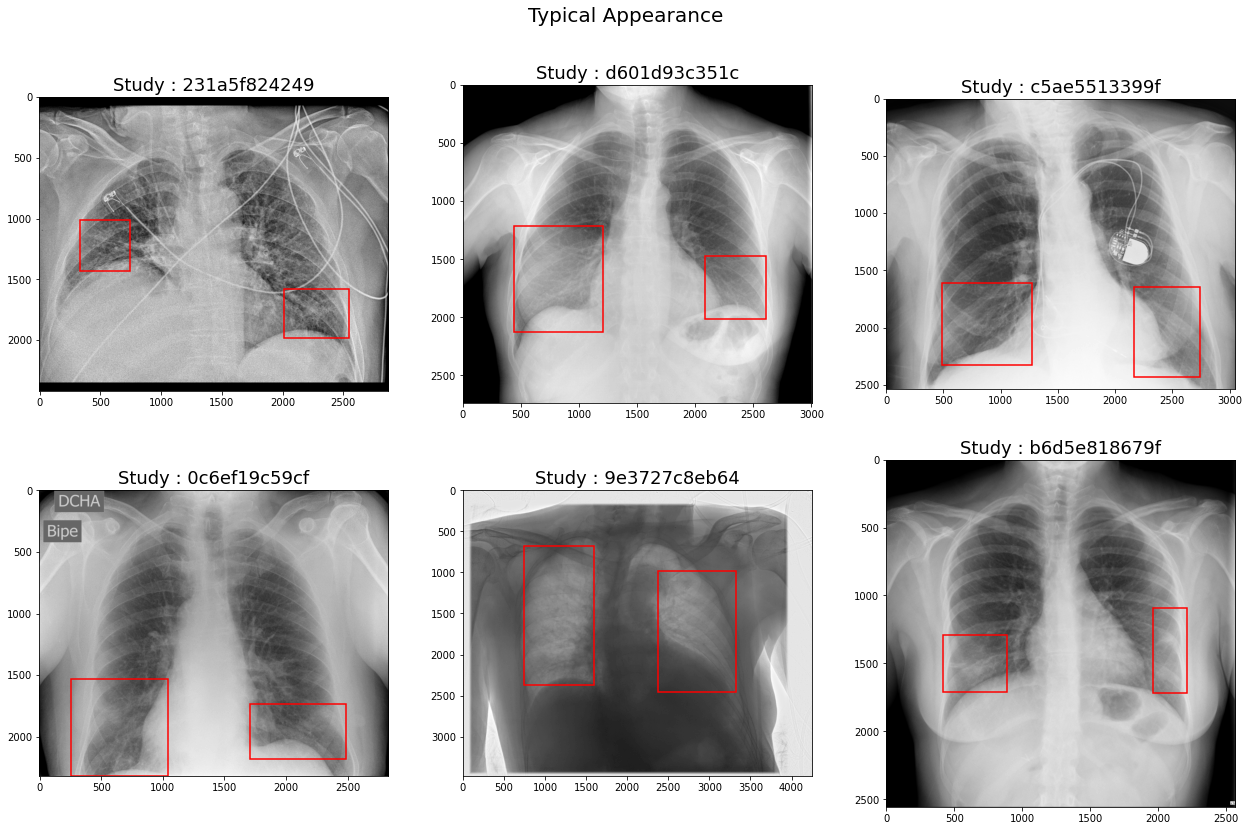

In [28]:

display_samples(samples['Typical Appearance'],'Typical Appearance', draw_boxes=True)

# Indeterminate Apearance 

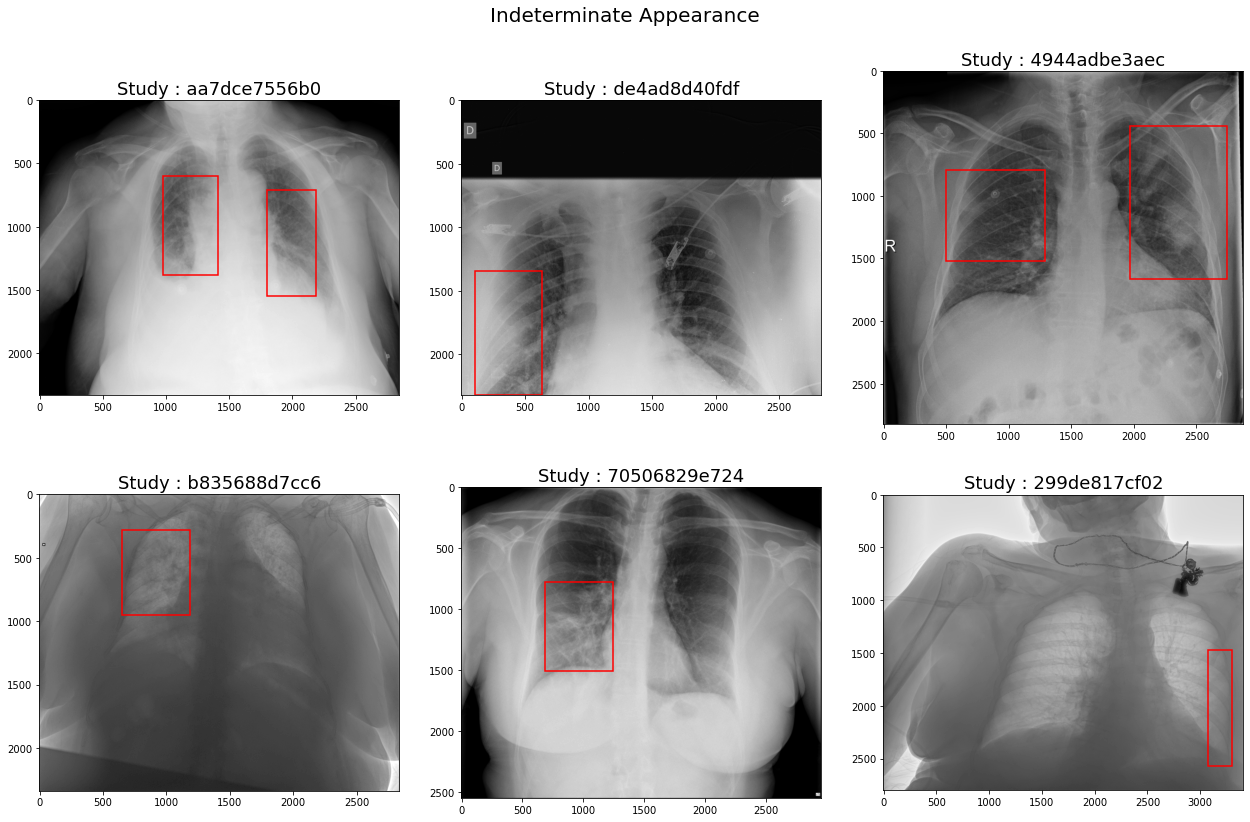

In [29]:
display_samples(samples['Indeterminate Appearance'],'Indeterminate Appearance', draw_boxes=True)

# Atypical Appearance

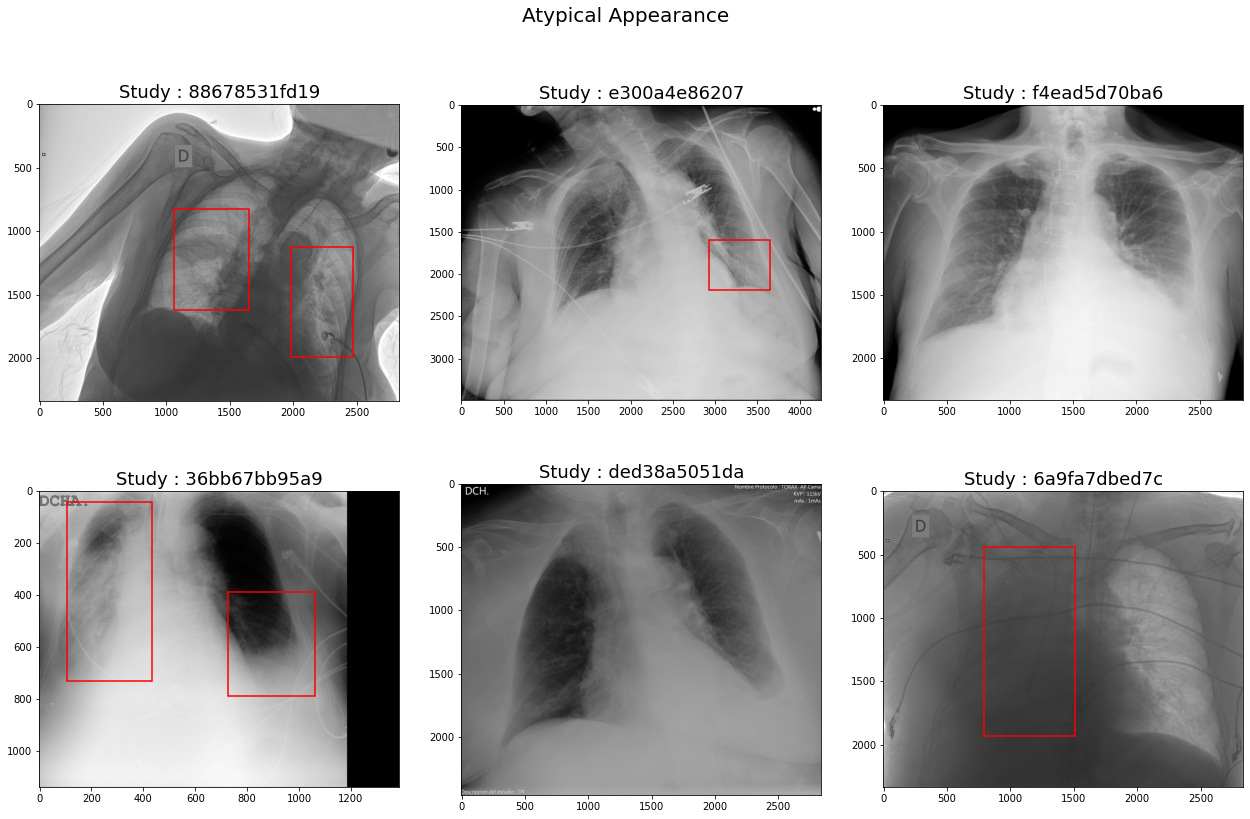

In [30]:
display_samples(samples['Atypical Appearance'],'Atypical Appearance', draw_boxes=True)

# Preprocessing

In [31]:
train_image

,id,boxes,label,StudyInstanceUID,split_label
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]"
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[[none, 1, 0, 0, 1, 1]]"
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[[opacity, 1, 677.42216, 197.97662, 1545.21983, 1197.75876], [opacity, 1, 1792.69064, 402.5525, 2409.71798, 1606.9105]]"
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[[opacity, 1, 2729, 2181.33331, 3677.00012, 2785.33331]]"
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[[opacity, 1, 623.23328, 1050, 1337.23328, 2156], [opacity, 1, 2578.56661, 998.66667, 3241.23328, 2118.66667]]"
...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,"[[none, 1, 0, 0, 1, 1]]"
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,"[[none, 1, 0, 0, 1, 1]]"
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814,"[[opacity, 1, 2197.38566, 841.07361, 2513.80265, 1292.71119], [opacity, 1, 2375.87717, 1830.89015, 2643.6144700000004, 2136.48927], [opacity, 1, 707.25199, 722.07926, 1099.3924299999999, 1571.26609]]"
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d,"[[opacity, 1, 2729.27083, 332.26044, 4225.52099, 2936.84378], [opacity, 1, 1005.8125, 1584.67711, 1668.0416300000002, 2360.51048]]"


# Opacity count

In [32]:
OpacityCount = train_image['label'].str.count('opacity')
OpacityCount

0       2
1       0
2       2
3       1
4       2
       ..
6329    0
6330    0
6331    3
6332    2
6333    2
Name: label, Length: 6334, dtype: int64

In [33]:
train_image['OpacityCount'] = OpacityCount.values
train_image

,id,boxes,label,StudyInstanceUID,split_label,OpacityCount
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]",2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[[none, 1, 0, 0, 1, 1]]",0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[[opacity, 1, 677.42216, 197.97662, 1545.21983, 1197.75876], [opacity, 1, 1792.69064, 402.5525, 2409.71798, 1606.9105]]",2
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[[opacity, 1, 2729, 2181.33331, 3677.00012, 2785.33331]]",1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[[opacity, 1, 623.23328, 1050, 1337.23328, 2156], [opacity, 1, 2578.56661, 998.66667, 3241.23328, 2118.66667]]",2
...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,"[[none, 1, 0, 0, 1, 1]]",0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,"[[none, 1, 0, 0, 1, 1]]",0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814,"[[opacity, 1, 2197.38566, 841.07361, 2513.80265, 1292.71119], [opacity, 1, 2375.87717, 1830.89015, 2643.6144700000004, 2136.48927], [opacity, 1, 707.25199, 722.07926, 1099.3924299999999, 1571.26609]]",3
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d,"[[opacity, 1, 2729.27083, 332.26044, 4225.52099, 2936.84378], [opacity, 1, 1005.8125, 1584.67711, 1668.0416300000002, 2360.51048]]",2


# Simplify ID for merge

In [34]:
id_extract = lambda x: x[0]

In [35]:
train_study

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


In [36]:
train_study['id'].str.split('_')

0       [00086460a852, study]
1       [000c9c05fd14, study]
2       [00292f8c37bd, study]
3       [005057b3f880, study]
4       [0051d9b12e72, study]
                ...          
6049    [ffcb4630f46f, study]
6050    [ffe4d6e8fbb0, study]
6051    [ffe94fcb14fa, study]
6052    [ffebf1ef4a9c, study]
6053    [fff649d65f62, study]
Name: id, Length: 6054, dtype: object

In [37]:
train_study['id'].str.split('_').apply(id_extract)

0       00086460a852
1       000c9c05fd14
2       00292f8c37bd
3       005057b3f880
4       0051d9b12e72
            ...     
6049    ffcb4630f46f
6050    ffe4d6e8fbb0
6051    ffe94fcb14fa
6052    ffebf1ef4a9c
6053    fff649d65f62
Name: id, Length: 6054, dtype: object

In [38]:
train_study['id'] = train_study['id'].str.split('_').apply(id_extract)

In [39]:
sum(train_study['id'].str.contains(train_image['StudyInstanceUID'][0]))

1

In [40]:
train_study = train_study.rename({'id':'StudyInstanceUID'}, axis=1)

In [41]:
train_study

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f,0,1,0,0
6050,ffe4d6e8fbb0,0,1,0,0
6051,ffe94fcb14fa,0,1,0,0
6052,ffebf1ef4a9c,0,1,0,0


In [42]:
train_df = pd.merge(train_image, train_study, on='StudyInstanceUID')
train_df

,id,boxes,label,StudyInstanceUID,split_label,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]",2,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[[none, 1, 0, 0, 1, 1]]",0,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[[opacity, 1, 677.42216, 197.97662, 1545.21983, 1197.75876], [opacity, 1, 1792.69064, 402.5525, 2409.71798, 1606.9105]]",2,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[[opacity, 1, 2729, 2181.33331, 3677.00012, 2785.33331]]",1,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[[opacity, 1, 623.23328, 1050, 1337.23328, 2156], [opacity, 1, 2578.56661, 998.66667, 3241.23328, 2118.66667]]",2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,"[[none, 1, 0, 0, 1, 1]]",0,1,0,0,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,"[[none, 1, 0, 0, 1, 1]]",0,1,0,0,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814,"[[opacity, 1, 2197.38566, 841.07361, 2513.80265, 1292.71119], [opacity, 1, 2375.87717, 1830.89015, 2643.6144700000004, 2136.48927], [opacity, 1, 707.25199, 722.07926, 1099.3924299999999, 1571.26609]]",3,0,1,0,0
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d,"[[opacity, 1, 2729.27083, 332.26044, 4225.52099, 2936.84378], [opacity, 1, 1005.8125, 1584.67711, 1668.0416300000002, 2360.51048]]",2,0,1,0,0


In [43]:
len(train_df['StudyInstanceUID'].unique())

6054

In [44]:
train_image['StudyInstanceUID'].unique().sort() == train_study['StudyInstanceUID'].unique().sort()

True

In [45]:
train_df['OpacityCount'].value_counts()

2    3113
0    2040
1     973
3     183
4      23
8       1
5       1
Name: OpacityCount, dtype: int64

In [46]:
train_df.iloc[:,6:].columns

Index(['Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance'],
      dtype='object')

In [47]:
sum(train_df['OpacityCount']==1)

973

In [48]:
for _, row in train_df.iloc[:5].iterrows():
    print(row)

id                                                                                                                                                                   000a312787f2_image
boxes                       [{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]
label                                                                           opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472
StudyInstanceUID                                                                                                                                                           5776db0cec75
split_label                                                    [[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]
OpacityCount                                                                    

In [49]:
from glob import glob

In [50]:
for _, row in train_df.iloc[:5].iterrows():
    image_id = row['id'].split('_')[0]
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{path}/train/{study_id}/*/{image_id}.dcm')
    print(img_path)

['../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm']
['../input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm']
['../input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm']
['../input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm']
['../input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm']


In [51]:
path_list = []
for _, row in train_df.iterrows():
    image_id = row['id'].split('_')[0]
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{path}/train/{study_id}/*/{image_id}.dcm')
    if len(img_path)==1:
        path_list.append(img_path[0])
    else:
        print(img_path)

In [52]:
len(path_list)

6334

In [53]:
path_list[:10]

['../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm',
 '../input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm',
 '../input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm',
 '../input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm',
 '../input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm',
 '../input/siim-covid19-detection/train/84543edc24c2/82f65ab98ee0/0022227f5adf.dcm',
 '../input/siim-covid19-detection/train/2fa400b873f5/0d5c637b277d/0023f02ae886.dcm',
 '../input/siim-covid19-detection/train/0717c8ac304f/849b8c217a5e/002e9b2128d0.dcm',
 '../input/siim-covid19-detection/train/a81050391441/85b77baa8ffe/00326161e51e.dcm',
 '../input/siim-covid19-detection/train/b60f2d2cc642/72527a76d460/0044e449aae1.dcm']

In [54]:
train_df['Path'] = path_list

In [55]:
train_df

,id,boxes,label,StudyInstanceUID,split_label,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]",2,0,1,0,0,../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[[none, 1, 0, 0, 1, 1]]",0,1,0,0,0,../input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[[opacity, 1, 677.42216, 197.97662, 1545.21983, 1197.75876], [opacity, 1, 1792.69064, 402.5525, 2409.71798, 1606.9105]]",2,0,1,0,0,../input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[[opacity, 1, 2729, 2181.33331, 3677.00012, 2785.33331]]",1,0,0,0,1,../input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[[opacity, 1, 623.23328, 1050, 1337.23328, 2156], [opacity, 1, 2578.56661, 998.66667, 3241.23328, 2118.66667]]",2,0,1,0,0,../input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm
...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,"[[none, 1, 0, 0, 1, 1]]",0,1,0,0,0,../input/siim-covid19-detection/train/7e6c68462e06/98011bca5fd2/ffcc6edd9445.dcm
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,"[[none, 1, 0, 0, 1, 1]]",0,1,0,0,0,../input/siim-covid19-detection/train/8332bdaddb6e/f346cda52da0/ffd91a2c4ca0.dcm
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814,"[[opacity, 1, 2197.38566, 841.07361, 2513.80265, 1292.71119], [opacity, 1, 2375.87717, 1830.89015, 2643.6144700000004, 2136.48927], [opacity, 1, 707.25199, 722.07926, 1099.3924299999999, 1571.26609]]",3,0,1,0,0,../input/siim-covid19-detection/train/7eed9af03814/668a64e3a5fa/ffd9b6cf2961.dcm
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d,"[[opacity, 1, 2729.27083, 332.26044, 4225.52099, 2936.84378], [opacity, 1, 1005.8125, 1584.67711, 1668.0416300000002, 2360.51048]]",2,0,1,0,0,../input/siim-covid19-detection/train/a0cb0b96fb3d/ccf363aa080f/ffdc682f7680.dcm


In [56]:
train_df.to_csv('train_df.csv')

In [57]:
pwd

'/kaggle/working'

In [58]:
ls

__notebook__.ipynb  train_df.csv


In [59]:
train_df = pd.read_csv("./train_df.csv")

In [60]:
train_df.head()

,Unnamed: 0,id,boxes,label,StudyInstanceUID,split_label,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Path
0,0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[['opacity', '1', '789.28836', '582.43035', '1815.94498', '2499.73327'], ['opacity', '1', '2245.91208', '591.20528', '3340.5737', '2352.75472']]",2,0,1,0,0,../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
1,1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[['none', '1', '0', '0', '1', '1']]",0,1,0,0,0,../input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm
2,2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[['opacity', '1', '677.42216', '197.97662', '1545.21983', '1197.75876'], ['opacity', '1', '1792.69064', '402.5525', '2409.71798', '1606.9105']]",2,0,1,0,0,../input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm
3,3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[['opacity', '1', '2729', '2181.33331', '3677.00012', '2785.33331']]",1,0,0,0,1,../input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm
4,4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[['opacity', '1', '623.23328', '1050', '1337.23328', '2156'], ['opacity', '1', '2578.56661', '998.66667', '3241.23328', '2118.66667']]",2,0,1,0,0,../input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm


Drop 'path' column

In [61]:
train_df.drop(columns = 'split_label', axis=1, inplace=True)
train_df.drop(columns = 'Path', axis=1, inplace=True)

In [62]:
train_df.head()

,Unnamed: 0,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,2,0,1,0,0
1,1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
2,2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,2,0,1,0,0
3,3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1
4,4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,2,0,1,0,0


Add opacity column 
* if opacity 1
* no opacity 0

In [63]:
train_df['Opacity'] = train_df.apply(lambda row : 1 if row.label.split(' ')[0]=='opacity' else 0, axis=1)
train_df

,Unnamed: 0,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity
0,0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,2,0,1,0,0,1
1,1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0
2,2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,2,0,1,0,0,1
3,3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1
4,4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,2,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6329,6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0,0
6330,6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,0,1,0,0,0,0
6331,6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814,3,0,1,0,0,1
6332,6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d,2,0,1,0,0,1


In [64]:
train_df.drop(columns=['Unnamed: 0'], inplace=True)
train_df

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,2,0,1,0,0,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,2,0,1,0,0,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,2,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,0,1,0,0,0,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814,3,0,1,0,0,1
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d,2,0,1,0,0,1


Meta csv

In [65]:
meta_df = pd.read_csv('../input/siim-covid19-resized-to-256px-jpg/meta.csv')

In [66]:
meta_df.head()

,image_id,dim0,dim1,split
0,a29c5a68b07b,2320,2828,test
1,9850b5470fd6,2330,2382,test
2,8d6dea06a032,2422,3344,test
3,dfc5c09a50bc,1140,1387,test
4,7230234e120a,2318,2383,test


In [67]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7597 entries, 0 to 7596
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  7597 non-null   object
 1   dim0      7597 non-null   int64 
 2   dim1      7597 non-null   int64 
 3   split     7597 non-null   object
dtypes: int64(2), object(2)
memory usage: 237.5+ KB


In [68]:
meta_df.split.unique()

array(['test', 'train'], dtype=object)

In [69]:
import warnings
warnings.filterwarnings(action='ignore')

In [70]:
train_meta_df = meta_df.loc[meta_df.split=='train']
train_meta_df.drop('split', axis=1, inplace=True)
train_meta_df.columns = ['id', 'origin_img_height','origin_img_width']
train_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6334 entries, 1263 to 7596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 6334 non-null   object
 1   origin_img_height  6334 non-null   int64 
 2   origin_img_width   6334 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 197.9+ KB


In [71]:
train_meta_df

,id,origin_img_height,origin_img_width
1263,d8ba599611e5,2336,2836
1264,29b23a11d1e4,3488,4256
1265,8174f49500a5,2330,2846
1266,d54f6204b044,2330,2846
1267,d51cadde8626,3488,4256
...,...,...,...
7592,729eca7b4c1c,2539,3050
7593,39d52f244db3,2320,2832
7594,d342f75ccb55,2320,2832
7595,0f0b5a304a47,2320,2832


In [72]:
train_df.head()

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,2,0,1,0,0,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,2,0,1,0,0,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,2,0,1,0,0,1


In [73]:
#lambda
train_df['id'].apply(lambda x : x.split('_')[0])

0       000a312787f2
1       000c3a3f293f
2       0012ff7358bc
3       001398f4ff4f
4       001bd15d1891
            ...     
6329    ffcc6edd9445
6330    ffd91a2c4ca0
6331    ffd9b6cf2961
6332    ffdc682f7680
6333    ffe942c8655f
Name: id, Length: 6334, dtype: object

In [74]:
train_df['id'] = train_df['id'].apply(lambda x : x.split('_')[0])

In [75]:
train_df.head()

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,2,0,1,0,0,1
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,2,0,1,0,0,1
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,2,0,1,0,0,1


In [76]:
train_df = pd.merge(train_df, train_meta_df, on='id')

In [77]:
train_df.head()

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity,origin_img_height,origin_img_width
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,2,0,1,0,0,1,3488,4256
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0,2320,2832
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,2,0,1,0,0,1,2544,3056
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1,3520,4280
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,2,0,1,0,0,1,2800,3408


In [78]:
pwd

'/kaggle/working'

In [79]:
path = '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/'
train_imgs_path = list(train_df['id'].apply(lambda x : path + x + '.jpg').values)
train_imgs_path[:10]

['/kaggle/input/siim-covid19-resized-to-256px-jpg/train/000a312787f2.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/000c3a3f293f.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/0012ff7358bc.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/001398f4ff4f.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/001bd15d1891.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/0022227f5adf.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/0023f02ae886.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/002e9b2128d0.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/00326161e51e.jpg',
 '/kaggle/input/siim-covid19-resized-to-256px-jpg/train/0044e449aae1.jpg']

In [80]:
img = plt.imread(train_imgs_path[0])

In [81]:
img.shape

(256, 256)

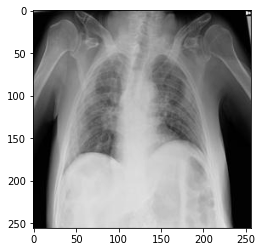

In [82]:
plt.imshow(img, cmap='gray');

In [83]:
i = 0
train_imgs = []
for img_path in train_imgs_path:
    img = plt.imread(img_path)
    train_imgs.append(img)
    i += 1
    if i%1000 == 0:
        print('{} / {}'.format(i, len(train_imgs_path)))
    elif i == 6334:
            print('6334/6334 (End)')

1000 / 6334
2000 / 6334
3000 / 6334
4000 / 6334
5000 / 6334
6000 / 6334
6334/6334 (End)


In [84]:
type(train_imgs)

list

In [85]:
train_imgs = np.array(train_imgs)

In [86]:
train_imgs.shape

(6334, 256, 256)

In [87]:
train_imgs_path[0]

'/kaggle/input/siim-covid19-resized-to-256px-jpg/train/000a312787f2.jpg'

In [88]:
train_imgs[:,:,:,np.newaxis].shape

(6334, 256, 256, 1)

In [89]:
train_imgs_4dim = train_imgs[:,:,:,np.newaxis]
train_imgs_4dim.shape

(6334, 256, 256, 1)

In [90]:
len(train_imgs)

6334

In [91]:
min(train_imgs[0].reshape(-1)), max(train_imgs[0].reshape(-1))

(0, 255)

In [92]:
min(train_imgs[13].reshape(-1)), max(train_imgs[13].reshape(-1))

(0, 255)

# Image resize ratio

In [93]:
train_df['origin_img_height']

0       3488
1       2320
2       2544
3       3520
4       2800
        ... 
6329    4240
6330    2800
6331    2388
6332    3488
6333    1140
Name: origin_img_height, Length: 6334, dtype: int64

In [94]:
train_df['height_ratio'] = train_df['origin_img_height'].apply(lambda x: 255/x)
train_df['height_ratio']

0       0.073108
1       0.109914
2       0.100236
3       0.072443
4       0.091071
          ...   
6329    0.060142
6330    0.091071
6331    0.106784
6332    0.073108
6333    0.223684
Name: height_ratio, Length: 6334, dtype: float64

In [95]:
train_df['origin_img_width']

0       4256
1       2832
2       3056
3       4280
4       3408
        ... 
6329    3480
6330    3408
6331    3050
6332    4256
6333    1387
Name: origin_img_width, Length: 6334, dtype: int64

In [96]:
train_df['width_ratio'] = train_df['origin_img_width'].apply(lambda x: 255/x)
train_df['height_ratio']

0       0.073108
1       0.109914
2       0.100236
3       0.072443
4       0.091071
          ...   
6329    0.060142
6330    0.091071
6331    0.106784
6332    0.073108
6333    0.223684
Name: height_ratio, Length: 6334, dtype: float64

In [97]:
train_df

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity,origin_img_height,origin_img_width,height_ratio,width_ratio
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,2,0,1,0,0,1,3488,4256,0.073108,0.059915
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0,2320,2832,0.109914,0.090042
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,2,0,1,0,0,1,2544,3056,0.100236,0.083442
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1,3520,4280,0.072443,0.059579
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,2,0,1,0,0,1,2800,3408,0.091071,0.074824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0,0,4240,3480,0.060142,0.073276
6330,ffd91a2c4ca0,NaN,none 1 0 0 1 1,8332bdaddb6e,0,1,0,0,0,0,2800,3408,0.091071,0.074824
6331,ffd9b6cf2961,"[{'x': 2197.38566, 'y': 841.07361, 'width': 316.41699, 'height': 451.63758}, {'x': 2375.87717, 'y': 1830.89015, 'width': 267.7373, 'height': 305.59912}, {'x': 707.25199, 'y': 722.07926, 'width': 392.14044, 'height': 849.18683}]",opacity 1 2197.38566 841.07361 2513.80265 1292.71119 opacity 1 2375.87717 1830.89015 2643.6144700000004 2136.48927 opacity 1 707.25199 722.07926 1099.3924299999999 1571.26609,7eed9af03814,3,0,1,0,0,1,2388,3050,0.106784,0.083607
6332,ffdc682f7680,"[{'x': 2729.27083, 'y': 332.26044, 'width': 1496.25016, 'height': 2604.58334}, {'x': 1005.8125, 'y': 1584.67711, 'width': 662.22913, 'height': 775.83337}]",opacity 1 2729.27083 332.26044 4225.52099 2936.84378 opacity 1 1005.8125 1584.67711 1668.0416300000002 2360.51048,a0cb0b96fb3d,2,0,1,0,0,1,3488,4256,0.073108,0.059915


In [98]:
types = list(train_df.columns[5:9])
types

['Negative for Pneumonia',
 'Typical Appearance',
 'Indeterminate Appearance',
 'Atypical Appearance']

In [99]:
path

'/kaggle/input/siim-covid19-resized-to-256px-jpg/train/'

In [100]:
train_imgs.shape

(6334, 256, 256)

# Sort images into each type of folder

In [101]:
!mkdir ./genData
!mkdir ./genData/Negative
!mkdir ./genData/Typical
!mkdir ./genData/Indeterminate
!mkdir ./genData/Atypical

In [102]:
# Negative for Pneumonia
imgs_Negative = list(train_df[train_df[types[0]]==1].index)
for idx in imgs_Negative:
    plt.imsave('./genData/Negative/{}.jpg'.format(train_df.loc[idx,'id']), train_imgs[idx], cmap='gray')

In [103]:
# Typical Apperance
imgs_Typical = list(train_df[train_df[types[1]]==1].index)
for idx in imgs_Typical:
    plt.imsave('./genData/Typical/{}.jpg'.format(train_df.loc[idx,'id']), train_imgs[idx], cmap='gray')

In [104]:
# Indeterminate Apearance
imgs_Indeterminate = list(train_df[train_df[types[2]]==1].index)
for idx in imgs_Indeterminate:
    plt.imsave('./genData/Indeterminate/{}.jpg'.format(train_df.loc[idx,'id']), train_imgs[idx], cmap='gray')

In [105]:
# Atypical Apearance
imgs_Atypical = list(train_df[train_df[types[3]]==1].index)
for idx in imgs_Atypical:
    plt.imsave('./genData/Atypical/{}.jpg'.format(train_df.loc[idx,'id']), train_imgs[idx], cmap='gray')

# Data Generation split-valid set

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [107]:
idg = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='reflect',
    validation_split=0.2
)

In [108]:
data_path = './genData'
batch_size = 64
target_size = (256, 256)
class_mode = 'categorical'
color_mode = 'grayscale'

In [109]:
train_gen = idg.flow_from_directory(
    data_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode=class_mode,
    color_mode=color_mode,
    subset = 'training'
)

valid_gen = idg.flow_from_directory(
    data_path,
    batch_size = batch_size,
    target_size = target_size,
    class_mode = class_mode,
    color_mode=color_mode,
    subset = 'validation'
)

Found 5069 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.


# Basic Multi-class classifier

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [111]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(256, 256,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [112]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [113]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)

In [114]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)

In [115]:
epochs = 1 # just for test
model.fit(
    train_gen,
    validation_data = (valid_gen),
    epochs = epochs,
    callbacks=[cp]
)

80/80 [==============================] - 553s 7s/step - loss: 1.3045 - acc: 0.4377 - val_loss: 1.2174 - val_acc: 0.4735

Epoch 00001: val_loss improved from inf to 1.21735, saving model to my_checkpoint.ckpt


In [116]:
model.load_weights(filepath)

In [117]:
model.evaluate(valid_gen)

20/20 [==============================] - 37s 2s/step - loss: 1.2180 - acc: 0.4735


[1.2180391550064087, 0.4735177755355835]

In [118]:
model.save('./model/basic_cnn.h5')

# Reload model

In [119]:
import tensorflow as tf

In [120]:
mymodel = tf.keras.models.load_model('./model/basic_cnn.h5')

In [121]:
mymodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [122]:
from tensorflow.keras.applications import EfficientNetB0

In [123]:
efc = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256,256,3))
efc.trainable=False

16711680/16705208 [==============================] - 0s 0us/step


In [124]:
model = Sequential([
    efc,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

In [125]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 81920)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               20971776  
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 25,022,375
Trainable params: 20,972,804
Non-trainable params: 4,049,571
_________________________________________________________________


In [126]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [127]:
filepath = 'my_checkpoint_efc.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)

In [128]:
epochs=1
model.fit(
    train_gen,
    validation_data=(valid_gen),
    epochs=epochs,
    callbacks=[cp]
)

80/80 [==============================] - 421s 5s/step - loss: 10.6307 - acc: 0.3493 - val_loss: 1.3785 - val_acc: 0.4751

Epoch 00001: val_loss improved from inf to 1.37846, saving model to my_checkpoint_efc.ckpt


In [129]:
model.load_weights(filepath)

In [130]:
model.evaluate(valid_gen)

20/20 [==============================] - 79s 4s/step - loss: 1.3785 - acc: 0.4751


[1.378455400466919, 0.4750988185405731]

In [131]:
idg = ImageDataGenerator(
    # rescale False
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='reflect',
    validation_split=0.2
)

In [132]:
data_path = './genData'
batch_size = 64
target_size = (224, 224)
class_mode = 'categorical'
color_mode = 'grayscale'

In [133]:
train_gen = idg.flow_from_directory(
    data_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode=class_mode,
    color_mode=color_mode,
    subset = 'training'
)

valid_gen = idg.flow_from_directory(
    data_path,
    batch_size = batch_size,
    target_size = target_size,
    class_mode = class_mode,
    color_mode=color_mode,
    subset = 'validation'
)

Found 5069 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.


In [134]:
efc = EfficientNetB0(weights='imagenet',
                     include_top=False, 
                     input_shape=(224,224,3),
                     drop_connect_rate=0.4)
efc.trainable=False

In [135]:
model = Sequential([
    efc,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

In [136]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [137]:
filepath = 'my_checkpoint_efc_224.ckpt'
cp = ModelCheckpoint(
    filepath = filepath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1
)

In [138]:
epochs=1
model.fit(
    train_gen,
    validation_data=(valid_gen),
    epochs=epochs,
    callbacks=[cp]
)

80/80 [==============================] - 327s 4s/step - loss: 4.6909 - acc: 0.4914 - val_loss: 1.0602 - val_acc: 0.6024

Epoch 00001: val_loss improved from inf to 1.06020, saving model to my_checkpoint_efc_224.ckpt


In [139]:
model.load_weights(filepath)

In [140]:
model.evaluate(valid_gen)

20/20 [==============================] - 59s 3s/step - loss: 1.0478 - acc: 0.6150


[1.0478129386901855, 0.6150197386741638]